100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Epoch [1/10] Loss D: 0.9643 Loss G: 5.9288
Epoch [2/10] Loss D: 0.6679 Loss G: 3.0141
Epoch [3/10] Loss D: 0.9618 Loss G: 1.3327
Epoch [4/10] Loss D: 0.4067 Loss G: 3.2419
Epoch [5/10] Loss D: 0.4864 Loss G: 2.7747
Epoch [6/10] Loss D: 4.4134 Loss G: 5.5585
Epoch [7/10] Loss D: 0.4803 Loss G: 2.7132
Epoch [8/10] Loss D: 0.4418 Loss G: 2.2966
Epoch [9/10] Loss D: 0.4208 Loss G: 2.6492
Epoch [10/10] Loss D: 0.4734 Loss G: 2.1954


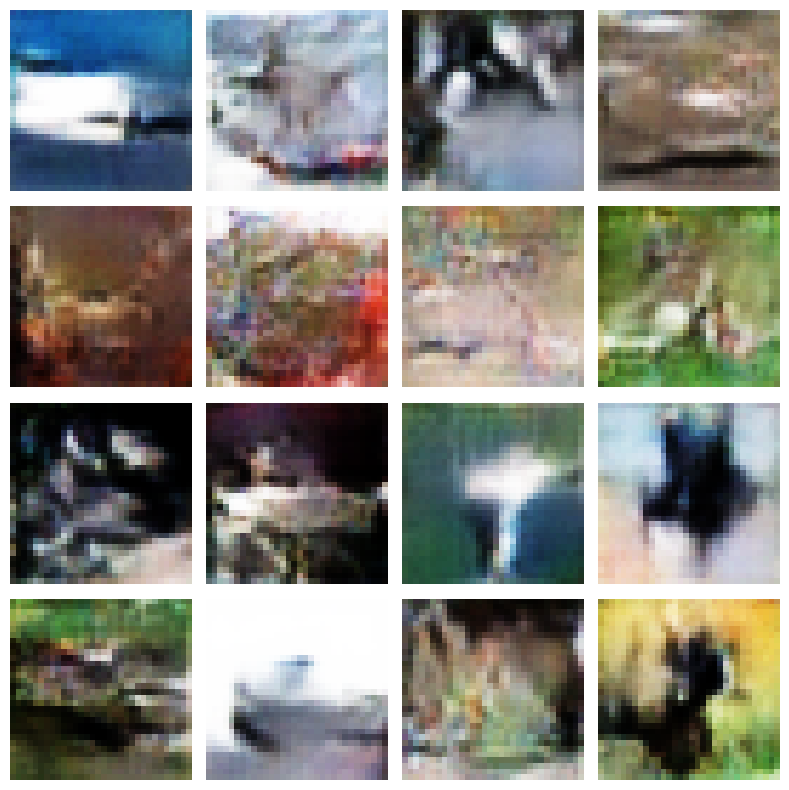

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
latent_dim = 100
img_size = 32  # Smaller for CIFAR-10
batch_size = 128
lr = 0.0002
epochs = 10  # Reduced for demo

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh())

    def forward(self, x): return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, x): return self.main(x).view(-1)

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Use CIFAR-10 instead of CelebA
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        D.zero_grad()
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Real images
        output = D(real_imgs)
        loss_real = criterion(output, real_labels)

        # Fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(noise)
        output = D(fake_imgs.detach())
        loss_fake = criterion(output, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        opt_D.step()

        # Train Generator
        G.zero_grad()
        output = D(fake_imgs)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        opt_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f} Loss G: {loss_G.item():.4f}")

# Generate samples
with torch.no_grad():
    noise = torch.randn(16, latent_dim, 1, 1, device=device)
    generated = G(noise).cpu()

# Display images
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(generated[i], (1,2,0))*0.5+0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()